In [19]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

digits = load_digits()
X = digits.data
y = digits.target

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
import numpy as np

class GaussianGenerativeModel:
    def fit(self, X, y):
        self.classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        self.means = [0] * 10
        self.priors = [0] * 10
        self.samples, self.features = X.shape
        X_centered = np.zeros((self.samples, self.features))

        for c in self.classes:
            X_c = X[y == c]

            # Calculate mean for class c
            mean_c = np.mean(X_c, axis=0)
            self.means[c] = mean_c

            # Calculate prior for class c
            prior_c = X_c.shape[0] / self.samples
            self.priors[c] = prior_c

            # Center the data for class c
            X_centered[y == c] = X_c - mean_c

        # Calculate shared covariance matrix
        self.shared_cov = np.dot(X_centered.T, X_centered) / self.samples

    def predict(self, X, lambda_reg):

        # Regularize covariance matrix and precompute its inverse
        cov_reg = self.shared_cov + lambda_reg * np.eye(self.features)
        cov_inv = np.linalg.inv(cov_reg)

        predictions = []
        for x in X:
            class_probs = [0] * 10
            for c in self.classes:
                mean_c = self.means[c]
                prior_c = self.priors[c]

                # Compute log-likelihood
                # Remove constant term bec same covariance for all classes
                diff = x - mean_c
                log_likelihood = -0.5 * np.dot(diff.T, np.dot(cov_inv, diff))

                # Compute log-posterior
                log_prior = np.log(prior_c)
                log_posterior = log_likelihood + log_prior

                class_probs[c] = log_posterior

            predicted_class = np.argmax(class_probs)
            predictions.append(predicted_class)

        return np.array(predictions)

In [22]:
# Initialize Model
LDA = GaussianGenerativeModel()
LDA.fit(X_train, y_train)

# Hyperparameter Tuning for Lambda
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
best_lambda = None
best_accuracy = 0
for lambda_reg in lambdas:
    y_val_pred = LDA.predict(X_val, lambda_reg)
    val_accuracy = np.mean(y_val_pred == y_val)
    if best_lambda is None or val_accuracy >= best_accuracy:
        best_accuracy = val_accuracy
        best_lambda = lambda_reg
    print(f"Validation Accuracy with lambda = {lambda_reg}: {val_accuracy}")


Validation Accuracy with lambda = 0.0001: 0.9444444444444444
Validation Accuracy with lambda = 0.001: 0.9444444444444444
Validation Accuracy with lambda = 0.01: 0.9444444444444444
Validation Accuracy with lambda = 0.1: 0.9444444444444444
Validation Accuracy with lambda = 1: 0.9222222222222223
Validation Accuracy with lambda = 10: 0.8481481481481481
Validation Accuracy with lambda = 100: 0.8111111111111111


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Train and Val Sets
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

# Retrain on Combined Set with Best Lambda
LDA.fit(X_combined, y_combined)
y_test_pred = LDA.predict(X_test, best_lambda)

# Evaluation Metrics
test_acc = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_test_pred)


FINAL TEST RESULTS
------------------------------
Test Accuracy:      96.2963%
Macro Precision:    0.9632
Macro Recall:       0.9627
Macro F1-Score:     0.9625


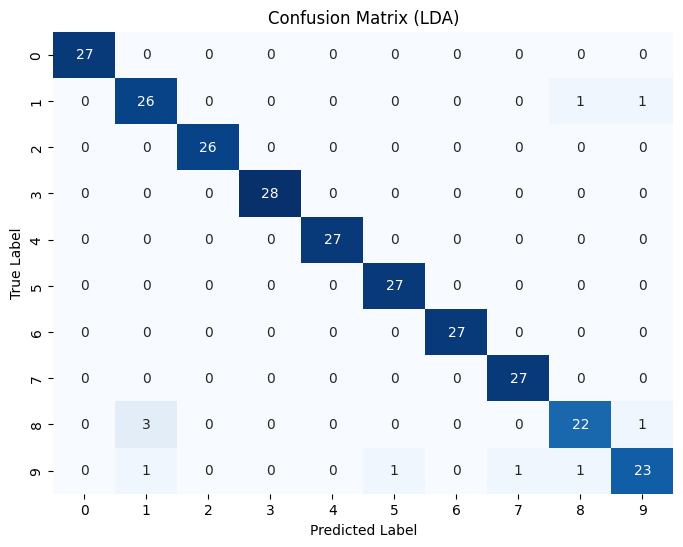

In [24]:
# Final Results
print("FINAL TEST RESULTS")
print("-" * 30)
print(f"Test Accuracy:      {test_acc:.4%}")
print(f"Macro Precision:    {precision:.4f}")
print(f"Macro Recall:       {recall:.4f}")
print(f"Macro F1-Score:     {f1:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (LDA)')
plt.show()

# Overview:

Gaussian Discriminant Analysis is a generative probabilistic classifier. It models the distribution of the data variables $p(x|y)$ for each class and uses Bayes' Theorem to predict the class label.

### The Core Assumption: "Shared Shape"
The defining characteristic of LDA is that it assumes **all classes share the same Covariance Matrix ($\Sigma$)**.
* Every class has its own center (Mean $\mu_k$).
* Every class has the exact same spread and orientation (Covariance $\Sigma$).

### How it Works
1.  **Training:** The model calculates the center ($\mu$) of each class and the average "spread" ($\Sigma$) of the entire dataset.
2.  **Prediction:** To classify a new point, it calculates the probabilities of each class and classifies it as the class with highest probability.
3.  **Result:** It assigns the point to the closest class center (adjusted by the class prior probability).